# **Cavity detection**

In this notebook, we are going to use the *Chandra* data products for NGC&thinsp;4778 we obtained using the `repro_to_image.ipynb` notebook and we are going to the use the source-filled broad-band image to detect X-ray cavities using various methods: **unsharp masking**, **gaussian gradient magnitude fiilter**, **beta modelling**, and **CADET**.

## **Import**

In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from scipy.ndimage import center_of_mass, rotate

# Astropy
from astropy.wcs import WCS
from astropy.io import fits
from astropy.nddata import Cutout2D, CCDData

# Change to your path
os.chdir("NGC4778")
path = os.getcwd()

## **Load & crop image**


Using the X-ray image and based on the literature (e.g. 2MASS), specify the central coordinates in units of degrees. Also choose the width of the cropped image in units of pixels.

In [2]:
ra = 193.2738270 # degrees
dec = -9.2040004 # degrees
size = 512 # pixels

# Load image
with fits.open("broad_filled.fits") as file:
    wcs0 = WCS(file[0].header)
    data0 = file[0].data

# Crop image
x0, y0 = wcs0.wcs_world2pix(ra, dec, 0)
cutout = Cutout2D(data0, (x0, y0), (size, size), wcs=wcs0)
data, wcs = cutout.data, cutout.wcs

# Rescale by the lowest non-zero pixel value (necessary for flux images)
lowest = np.min(data[np.nonzero(data)])
data /= lowest

# Save cropped image
os.system(f"mkdir -p {path}/cavities")
hdu = fits.PrimaryHDU(data=data, header=wcs.to_header())
hdu.writeto(f"{path}/cavities/broad_crop.fits", overwrite=True)

Set MJD-END to 54893.839317 from DATE-END'. [astropy.wcs.wcs]


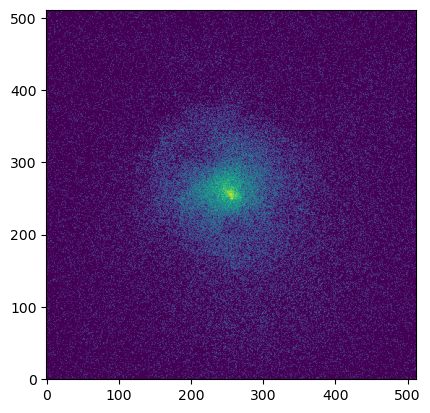

In [3]:
plt.imshow(np.log10(data+1), origin='lower');

## **Unsharp masking**

Now you need to specify the two scales, which will be used for smoothing the images. Both `scale1` and `scale2` can be set to an arbitrary number (even float numbers should be allowed) based on the size of the cavity. For small cavities, also the scales should be lower and vice versa. Usually, it is recommened to try multiple combinations of scales.

### **convolve (Astropy)**

In [4]:
from astropy.convolution import convolve, Gaussian2DKernel

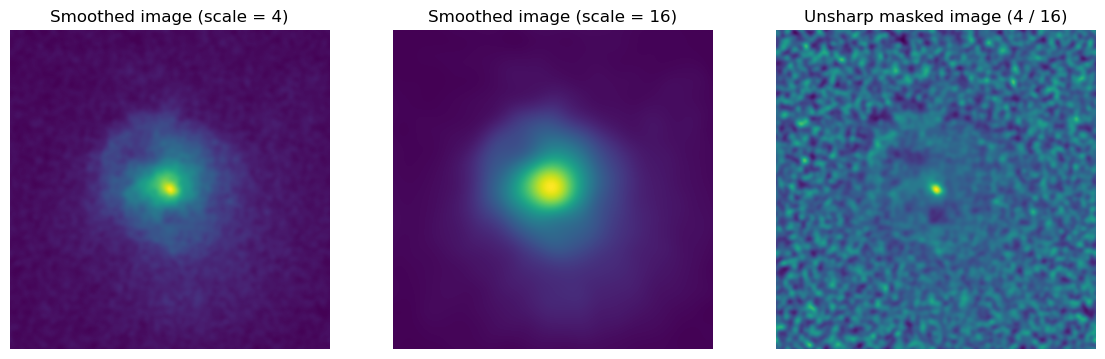

In [5]:
os.system(f"mkdir -p {path}/cavities/Unsharp_masking")
os.chdir(f"{path}/cavities/Unsharp_masking")

scale1 = 4
scale2 = 16

conv1 = convolve(data, Gaussian2DKernel(scale1), boundary="wrap")
conv2 = convolve(data, Gaussian2DKernel(scale2), boundary="wrap")
unsharped = conv1 / conv2

hdu = fits.PrimaryHDU(data=unsharped, header=wcs.to_header())
hdu.writeto(f"{path}/cavities/Unsharp_masking/unsharped_{scale1}-{scale2}_astropy.fits", overwrite=True)

plt.figure(figsize=(14,5))

plt.subplot(131)
plt.title(f"Smoothed image (scale = {scale1})")
plt.imshow(np.log10(conv1+1), origin='lower')
plt.axis('off')

plt.subplot(132)
plt.title(f"Smoothed image (scale = {scale2})")
plt.imshow(np.log10(conv2+1), origin='lower')
plt.axis('off')

plt.subplot(133)
plt.title(f"Unsharp masked image ({scale1} / {scale2})")
plt.imshow(unsharped, origin='lower')
plt.axis('off');

### **aconvolve (CIAO)**

In [6]:
from ciao_contrib.runtool import aconvolve, dmimgcalc

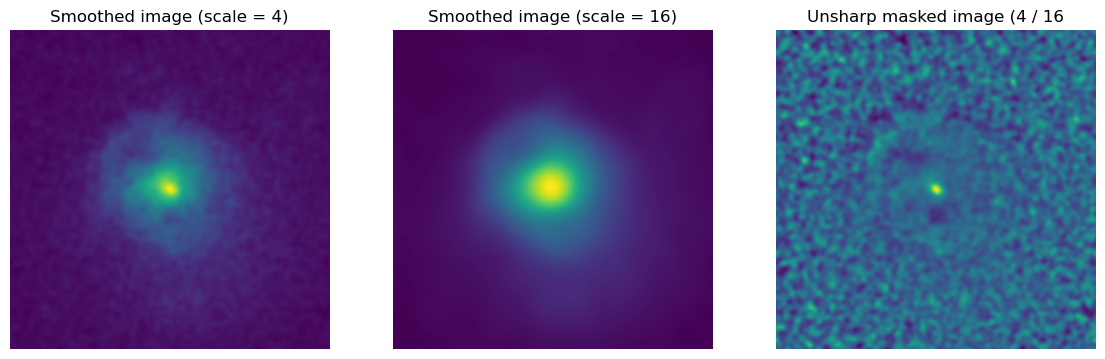

In [7]:
os.system(f"mkdir -p {path}/cavities/Unsharp_masking")
os.chdir(f"{path}/cavities/Unsharp_masking")

scale1 = 4
scale2 = 16

aconvolve(f"../broad_crop.fits", f"smooth_{scale1}.fits",
          f"lib:gaus(2,5,1,{scale1},{scale1})", clobber=True)

aconvolve(f"../broad_crop.fits", f"smooth_{scale2}.fits",
          f"lib:gaus(2,5,1,{scale2},{scale2})", clobber=True)

dmimgcalc(f"smooth_{scale1}.fits", f"smooth_{scale2}.fits",
          f"unsharped_{scale1}-{scale2}.fits", operation="div", clobber=True)

plt.figure(figsize=(14,5))

plt.subplot(131)
plt.title(f"Smoothed image (scale = {scale1})")
conv1 = fits.getdata(f"smooth_{scale1}.fits")
plt.imshow(np.log10(conv1+1), origin='lower')
plt.axis('off')

plt.subplot(132)
plt.title(f"Smoothed image (scale = {scale2})")
conv2 = fits.getdata(f"smooth_{scale2}.fits")
plt.imshow(np.log10(conv2+1), origin='lower')
plt.axis('off')

plt.subplot(133)
plt.title(f"Unsharp masked image ({scale1} / {scale2}")
unsharped = fits.getdata(f"unsharped_{scale1}-{scale2}.fits")
plt.imshow(unsharped, origin='lower')
plt.axis('off');

Now you can open the unsharp-masked image using DS9 (if installed on your system) and draw the cavities by eye using the ellipse regions.

```bash
!ds9 -scale linear unsharped_{scale1}-{scale2}.fits
```

In [8]:
!ds9 -scale linear unsharped_{scale1}-{scale2}.fits

## **Gaussian gradient magnitude filter**

In [9]:
from scipy.ndimage import gaussian_gradient_magnitude

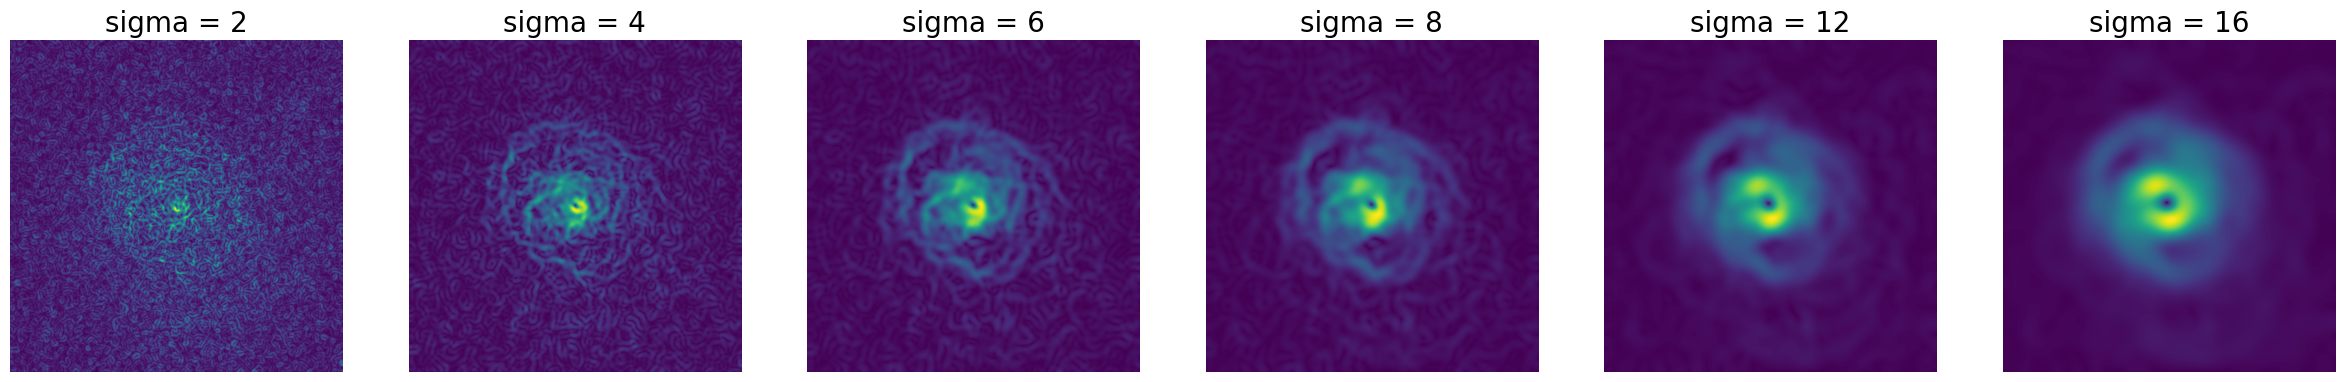

In [10]:
sigmas = [2, 4, 6, 8, 12, 16]

os.system(f"mkdir -p {path}/cavities/GGM")

fig, axs = plt.subplots(1, len(sigmas), figsize=(len(sigmas)*5,5))
for i, sigma in enumerate(sigmas):
    ax = axs[i]
    ggm = gaussian_gradient_magnitude(np.log10(data+1), sigma=sigma)
    ax.set_title(f"sigma = {sigma}", fontsize=20)
    ax.imshow(ggm, origin='lower');
    ax.axis('off')

    # SAVE FITS
    hdu = fits.PrimaryHDU(data=ggm, header=wcs.to_header())
    hdu.writeto(f"{path}/cavities/GGM/GGM_{sigma}.fits", overwrite=True)

## **Beta modelling**

Alternatively, you can use this [interactive tool](https://github.com/tomasplsek/Beta-modelling). 

In [11]:
from sherpa_contrib.profiles import get_data_prof, get_model_prof, get_resid_prof
from sherpa.astro.ui import get_model, get_data_image, get_model_image, get_resid_image, guess, freeze, load_image, link, fit, thaw, set_coord, set_stat, set_source, set_par, set_method, image_data, unlink

set_stat("cstat")
set_method("levmar")

os.system(f"mkdir -p {path}/cavities/Beta_model")

0

In [12]:
def plot_all():
    image = get_data_image().y
    model = get_model_image().y
    resid = get_resid_image().y

    # SMOOTH IMAGE
    size_to_std = {64 : 1, 128 : 1, 192 : 1.5, 256 : 2, 384 : 2.5, 512 : 3, 640 : 4, 768 : 5, 896 : 6, 1024 : 7, 2048 : 8}
    smooth_std = size_to_std[2*X0//128*128]
    image = convolve(image, boundary = "wrap", nan_treatment="interpolate",
                    kernel = Gaussian2DKernel(x_stddev = smooth_std, y_stddev = smooth_std))

    # SMOOTH RESIDUAL IMAGE
    resid = convolve(resid, boundary = "wrap", nan_treatment="interpolate",
                    kernel = Gaussian2DKernel(x_stddev = smooth_std, y_stddev = smooth_std))

    # TRIM RESID TO 5 SIGMA
    array = resid.flatten()
    std = np.std(array)*4
    resid = np.where(resid > std, std, resid)
    resid = np.where(resid < -std, -std, resid)

    # GET RADIAL PROFILE
    prof = get_data_prof(model=b1)
    rad = (prof.xlo + prof.xhi) / 2
    y, yerr = prof.y, prof.yerr
    y_fit = get_model_prof(model=b1).y
    res = (y-y_fit) / yerr

    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    axs[0,0].set_title("Radial profile", fontsize=13)
    axs[0,0].errorbar(rad, y, yerr=yerr, fmt='o', ms=5, color='C0')
    axs[0,0].plot(rad, y_fit, color='r', zorder=10)
    axs[0,0].set_xscale('log')
    axs[0,0].set_yscale('log')
    axs[0,0].set_xlabel("Radius (pixels)", labelpad=3)
    axs[0,0].set_ylabel("Counts")

    axs[0,1].set_title("Image", fontsize=13)
    axs[0,1].imshow(np.log10(image+1), origin='lower')
    axs[0,1].axis('off')

    axs[1,0].set_title("Model", fontsize=13)
    axs[1,0].imshow(np.log10(model+1), origin='lower')
    axs[1,0].axis('off')

    axs[1,1].set_title("Residual", fontsize=13)
    axs[1,1].imshow(resid, origin='lower', cmap="coolwarm")
    axs[1,1].axis('off');

((beta2d.b1 + beta2d.b2) + const2d.bkg)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   b1.r0        frozen            2  1.17549e-38  3.40282e+38           
   b1.xpos      thawed          256          216          296           
   b1.ypos      thawed          256          216          296           
   b1.ellip     frozen            0            0          0.7           
   b1.theta     frozen            0     -6.28319      6.28319    radians
   b1.ampl      thawed            5 -3.40282e+38  3.40282e+38           
   b1.alpha     thawed          1.8          0.1           10           
   b2.r0        frozen           24  1.17549e-38  3.40282e+38           
   b2.xpos      frozen          256          216          296           
   b2.ypos      frozen          256          216          296           
   b2.ellip     linked            0           expr: b1.ellip           
   b2.theta 

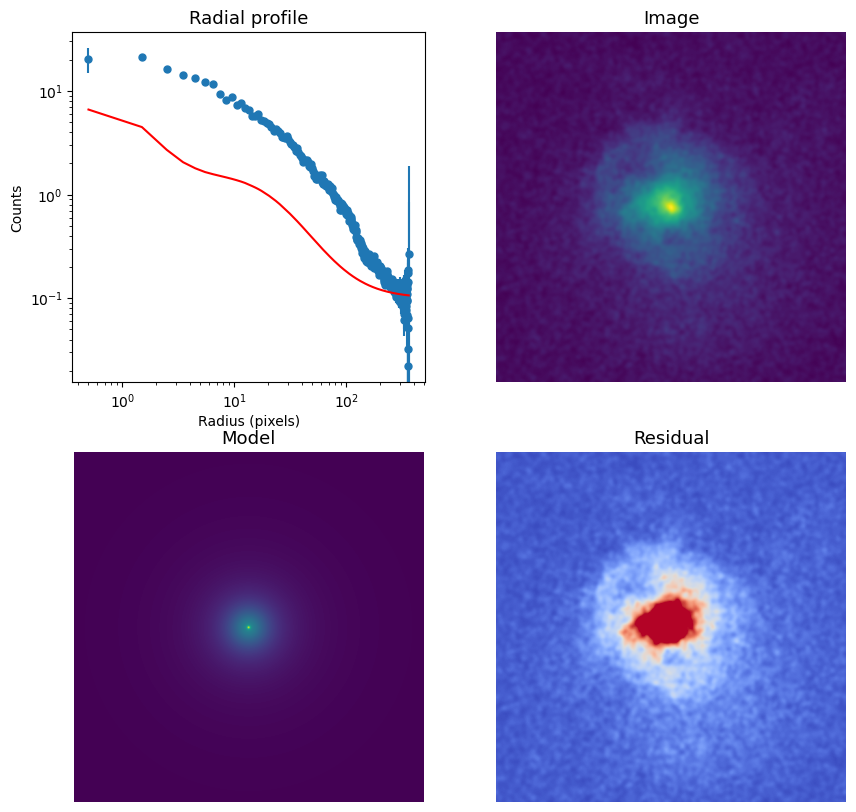

In [13]:
# LOAD IMAGE USING ASTROPY
fname = glob.glob(f"{path}/cavities/broad_crop.fits")[0]
file = fits.open(fname)
data = file[0].data
X0 = data.shape[0] / 2

# LOAD IMAGE INTO SHERPA
load_image(fname)
set_coord("image")

# SET MODEL
set_source("beta2d.b1 + beta2d.b2 + const2d.bkg")

fac = 40
set_par(b1.xpos, val=X0, min=X0-fac, max=X0+fac)
set_par(b1.ypos, val=X0, min=X0-fac, max=X0+fac)
set_par(b1.ellip, val=0, min=0, max=0.7)
set_par(b1.theta, val=0)
set_par(b1.r0, val=2, frozen=True)
set_par(b1.ampl, val=5)
set_par(b1.alpha, val=1.8, min=0.1, max=10)

set_par(b2.xpos, val=X0, min=X0-fac, max=X0+fac, frozen=True)
set_par(b2.ypos, val=X0, min=X0-fac, max=X0+fac, frozen=True)
# link(b2.xpos, b1.xpos)
# link(b2.ypos, b1.ypos)
link(b2.ellip, b1.ellip)
link(b2.theta, b1.theta)

set_par(b2.r0, val=24, frozen=True)
set_par(b2.ampl, val=1.5)
set_par(b2.alpha, val=1.0, min=0.1, max=10)

set_par(bkg.c0, val=0.1, min=0)

print(get_model())

plot_all()

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 292165
Final fit statistic   = 199256 at function evaluation 216
Data points           = 262144
Degrees of freedom    = 262137
Probability [Q-value] = 1
Reduced statistic     = 0.76012
Change in statistic   = 92909
   b1.xpos        255.782      +/- 0.209439    
   b1.ypos        257.132      +/- 0.208315    
   b1.ampl        19.7209      +/- 1.63487     
   b1.alpha       0.780053     +/- 0.0672843   
   b2.ampl        7.2915       +/- 0.224756    
   b2.alpha       0.900321     +/- 0.00670482  
   bkg.c0         0.0190608    +/- 0.00352898  
Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 199256
Final fit statistic   = 198710 at function evaluation 237
Data points           = 262144
Degrees of freedom    = 262135
Probability [Q-value] = 1
Reduced statistic     = 0.758046
Change in statistic   = 545.288
   b1.xpo

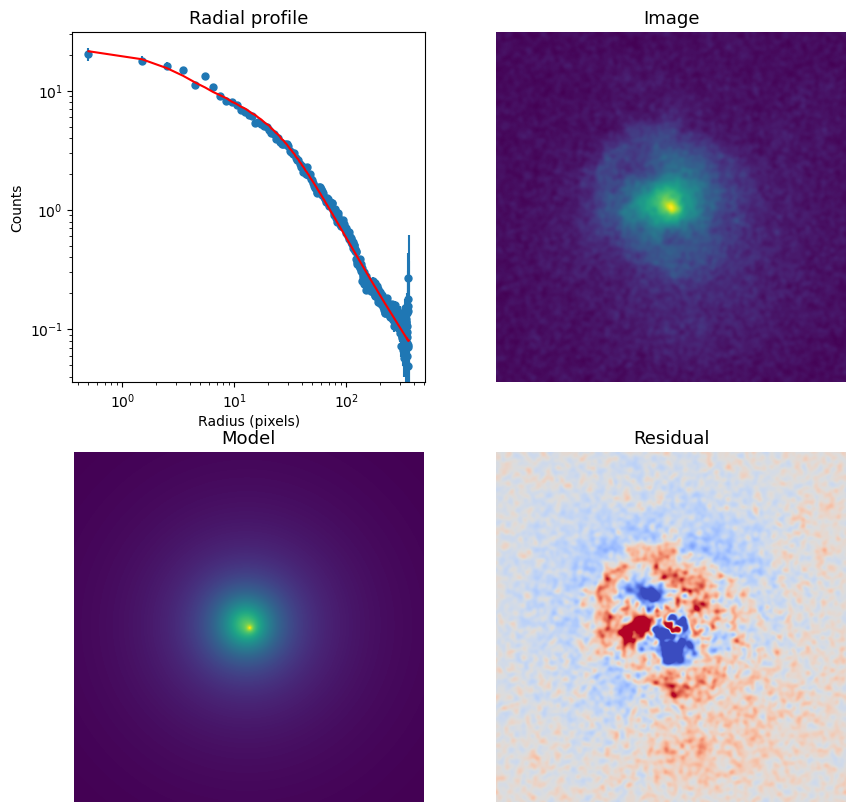

In [14]:
fit()
thaw(b2.xpos, b2.ypos)
fit()
plot_all()

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 198710
Final fit statistic   = 207566 at function evaluation 2826
Data points           = 262144
Degrees of freedom    = 262133
Probability [Q-value] = 1
Reduced statistic     = 0.791833
Change in statistic   = 8855.24
   b1.r0          3.44542      +/- 0.331349    
   b1.xpos        257.194      +/- 0.216309    
   b1.ypos        255.757      +/- 0.215401    
   b1.ampl        19.5679      +/- 1.92876     
   b1.alpha       0.550452     +/- 0.0246977   
   b2.r0          36.9198      +/- 2.53722     
   b2.xpos        249.78       +/- 0.495168    
   b2.ypos        262.121      +/- 0.468611    
   b2.ampl        4.61478      +/- 0.308946    
   b2.alpha       1.31814      +/- 0.104827    
   bkg.c0         0            +/- 0.0143271   
Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 207566
Final fit statistic   = 

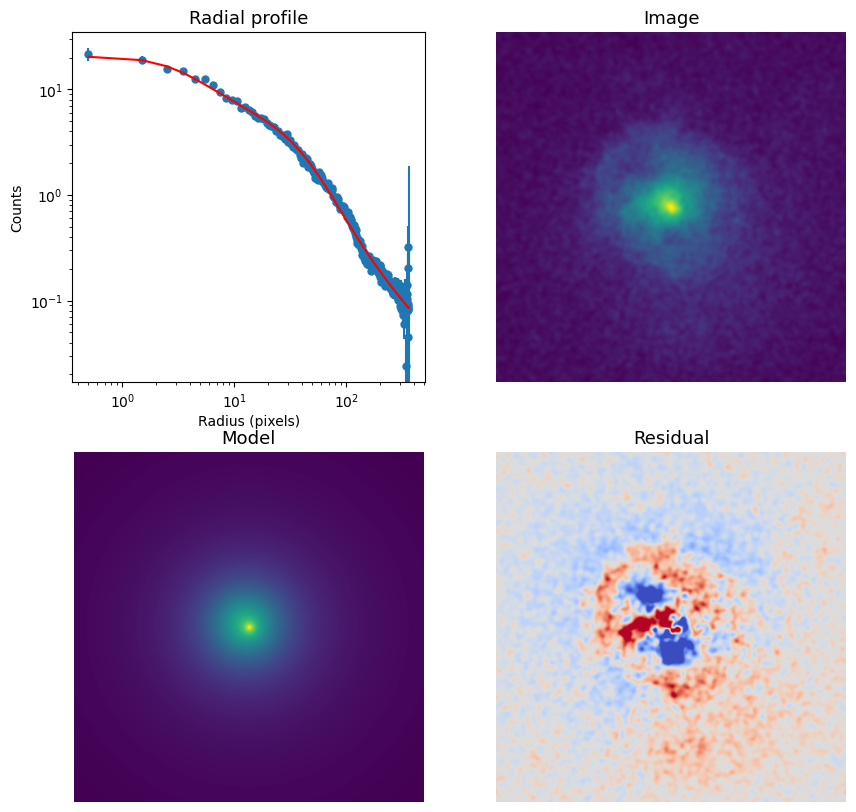

In [15]:
thaw(b1.r0, b2.r0)
fit()
fit()
plot_all()

In [16]:
# WRITE RESID TO FITS
resid = get_resid_image().y
file[0].data = resid
file.writeto(f"{path}/cavities/Beta_model/resid.fits", overwrite=True)

model = get_model_image().y
file[0].data = model
file.writeto(f"{path}/cavities/Beta_model/model.fits", overwrite=True)